<a href="https://colab.research.google.com/github/princ1211/MaskDetect/blob/main/Final_Model_tested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7293743314964681228]

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [7]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%pwd

'/content'

In [8]:
%cd /content/drive/MyDrive/face_detector-master

/content/drive/MyDrive/face_detector-master


# Train Model- 

In [15]:
dataset= "/content/drive/MyDrive/face_detector-master/dataset"

partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing

In [27]:
!python train_mask_detector.py --dataset dataset

2021-03-28 13:55:18.042604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
[INFO] loading images...
2021-03-28 14:00:16.544874: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-28 14:00:16.572905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-28 14:00:16.636934: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-28 14:00:16.637023: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (de564a9b0a24): /proc/driver/nvidia/version does not exist
2021-03-28 14:00:16.637830: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
9412608/9406464 [==============================] - 

#**Predict on Single Image**

In [5]:
pip install anvil-uplink

     |████████████████████████████████| 61kB 2.6MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45216 sha256=63b9dd1175266585be607cf07a949ea9f1b3c748282e3607663284b7fadc5b51
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


In [2]:
import anvil.server
anvil.server.connect("XTT6KUY3DNCNDWUH7GW5JLAX-ENO7KUPQVBH3JQV7")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [4]:
import anvil.media
@anvil.server.callable
def c_image(file):
  with anvil.media.TempFile as filename:
    image= load_img(filename)


[INFO] computing face detections...


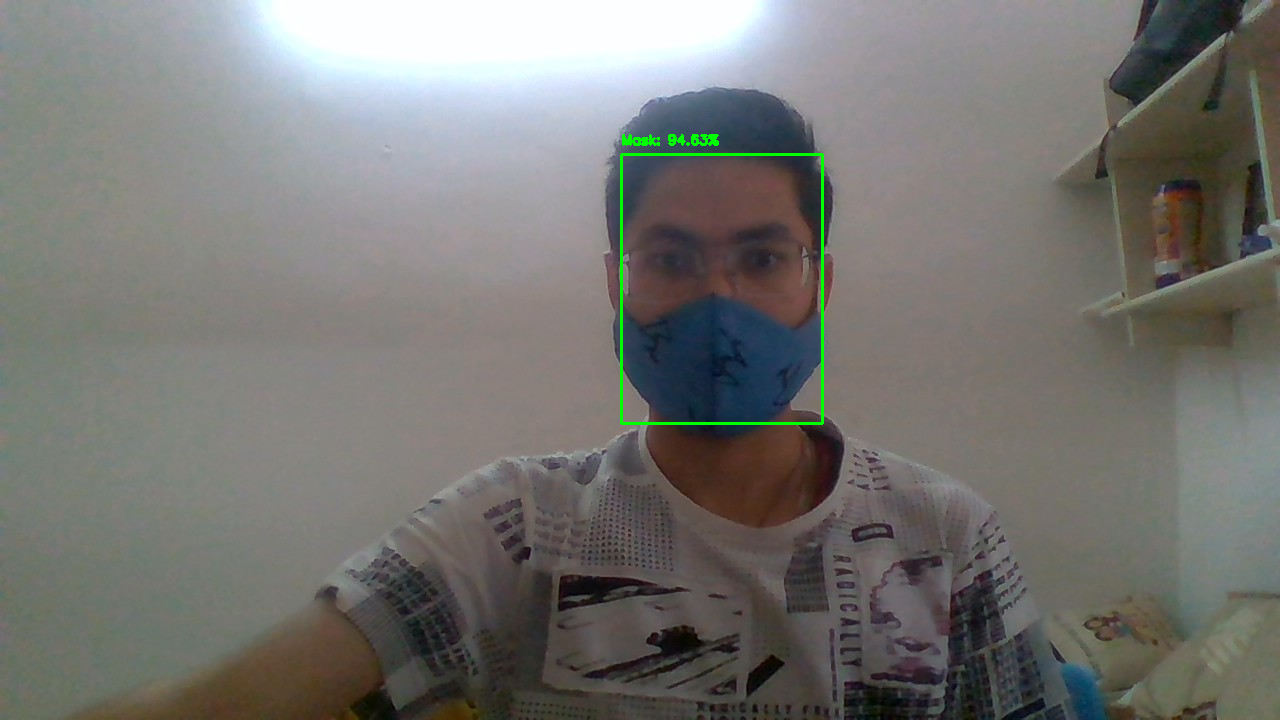

In [28]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

input_file_path = "/content/drive/MyDrive/test2.jpg"
prototxtPath = "/content/drive/MyDrive/face_detector-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/face_detector-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("/content/drive/MyDrive/face_detector-master/mask_detector.model")

def process_images(input_file_path):

	image = cv2.imread(input_file_path)

	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()
	for i in range(0, detections.shape[2]):
		
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:

			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			#Check if mask or not
			(mask, withoutMask) = model.predict(face)[0]
			label = "Mask" if mask > withoutMask else "No Mask"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

	
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)


	save_path = input_file_path.split(".",1)

	cv2_imshow(image)

process_images(input_file_path)

Loading webcam

Video Stream

In [35]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

For Uploaded Video

In [56]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from imutils.video import FPS

from google.colab.patches import cv2_imshow
import pdb

#Input video file path
input_video_path = "/content/drive/MyDrive/WIN_20210326_16_56_15_Pro.mp4"
path="haarcascade_frontalface_default.xml"

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		preds = maskNet.predict(faces)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/MyDrive/face_detector-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/face_detector-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model("/content/drive/MyDrive/face_detector-master/mask_detector.model")


img_array = []
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
VideoStream()
while True:
  
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

    # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  frame = imutils.resize(img, width=400)
  

    # convert JS response to OpenCV Image
	
    
    
  faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
  faces= faceCascade.detectMultiScale(gray,1.1,4)
  for x,y,w,h in faces:
      roi_gray=gray[y:y+h,x:x+w]
      roi_color= frame[y:y+h,x:x+w]
      cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
      facess=faceCascade.detectMultiScale(roi_gray)
      if len(facess)==0:
          print("Face not detected")
      else:
          for(ex,ey,ew,eh)in facess:
              face_roi=roi_color[ey:ey+eh,ex:ex+ew]
     
  final_image=cv2.resize(face_roi,(224,224))
  final_image=np.expand_dims(final_image,axis=0)
  final_image=final_image/255.0
  font= cv2.FONT_HERSHEY_SIMPLEX

  
  (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
  for (box, pred) in zip(locs, preds):
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    cv2.putText(frame, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    height, width, layers = frame.shape
    size = (width,height)
    img_array.append(frame)
    cv2_imshow(frame)
  if cv2.waitKey(2)& 0xFF==ord('q'):
    break
  
  cv2.destroyAllWindows()
	  
   
  
      
        



#Saving all output frames as MP4 video


# vs.stop()

Uploaded Image

In [57]:
# USAGE
# python detect_mask_video.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from imutils.video import FPS

from google.colab.patches import cv2_imshow
import pdb

#Input video file path
input_video_path = "/content/drive/MyDrive/WIN_20210326_16_56_15_Pro.mp4"

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		preds = maskNet.predict(faces)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/MyDrive/face_detector-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/face_detector-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model("mask_detector.model")

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
file_path = input_video_path.split(".",1)
vs = cv2.VideoCapture(input_video_path)
length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
time.sleep(2.0)

#checking video available or not
grabbed, frame_flip = vs.read()
if not(grabbed): print ("INPUT VIDEO NOT FOUND!")

# loop over the frames from the video stream
count = 0
img_array = []
while grabbed:
	faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    faces= faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color= frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        facess=faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print("Face not detected")
        else:
            for(ex,ey,ew,eh)in facess:
                face_roi=roi_color[ey:ey+eh,ex:ex+ew]
     
    final_image=cv2.resize(face_roi,(224,224))
    final_image=np.expand_dims(final_image,axis=0)
    final_image=final_image/255.0
    font= cv2.FONT_HERSHEY_SIMPLEX
	
	(locs, preds) = detect_and_predict_mask(final_image, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
	
	# cv2_imshow(frame)
	height, width, layers = frame.shape
	size = (width,height)
	img_array.append(frame)
	print ("\r[INFO] Count: {}/{}".format(count, length),end='')
	count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
video = cv2.VideoWriter(file_path[0] + "_OUTPUT." + file_path[-1], cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    video.write(img_array[i])
video.release()
print ("[INFO] process complete.")

# vs.stop()

IndentationError: ignored

TEst

#**Extract images from video (VIDEO -> IMAGES)**

In [ ]:
import cv2

# Opens the Video file
cap= cv2.VideoCapture('/content/drive/My Drive/test_vid.mp4')
i = 0
j = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)
    if ret == False:
        break
    cv2.imwrite('/content/drive/My Drive/face-mask-detector/examples/testImg/test_image_'+str(i)+'.jpg',frame)
    print ("\rCount: {}".format(i),end='')
    j+=1
    i+=1

# print ("\n[INFO] Next frame start with: {}".format(i))
print ("\n[INFO] Total frames: {}".format(j))
cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import glob
import pdb

input_folder_path = '/content/drive/My Drive/face-mask-detector/examples/testImg/'

#natural sorting
x = os.listdir(input_folder_path)
sorted_path = natsorted(x, key=lambda y: y.lower())
length = len(sorted_path)
count = 0
img_array = []
# for filename in glob.glob():
for filename in sorted_path:
    file_path = input_folder_path + filename
    img = cv2.imread(file_path)
    img = cv2.rotate(img, cv2.ROTATE_180)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    print ("\r[INFO] Count: {}/{}".format(count, length),end='')
    count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
out = cv2.VideoWriter('/content/drive/My Drive/face-mask-detector/examples/testImg_OUTPUT.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print ("[INFO] process complete.")